In [46]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

In [32]:
trace_batch = ts.generate(
        E=0,
        x=-40, y=80, z=-1800,
        no_noise=False,
        type_recoil='NR',
        quantize=False,
        phonon_only=False
    )  # shap

In [33]:
means = []
for i in range(trace_batch.shape[1]):
    means.append(np.mean(trace_batch[0][i]))

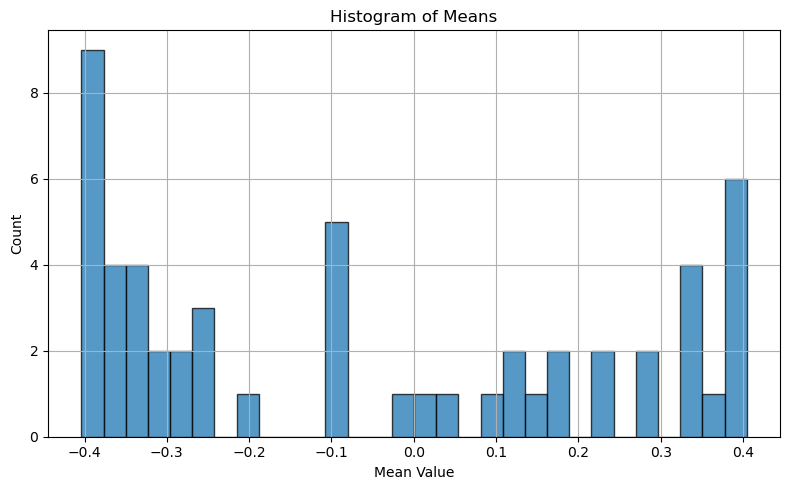

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Example: means from a set of traces
# Replace this with your actual means array
# e.g., means = np.mean(traces, axis=1)

plt.figure(figsize=(8, 5))
plt.hist(means, bins=30, edgecolor='black', alpha=0.75)
plt.title("Histogram of Means")
plt.xlabel("Mean Value")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt


In [20]:
ka_data_1 = np.load('/ceph/dwong/delight/Ka_traces_1.npz')
ka_data_2 = np.load('/ceph/dwong/delight/Ka_traces_2.npz')
kb_data = np.load('/ceph/dwong/delight/Kb_traces.npz')
traces_a = np.concatenate((ka_data_1['data'], ka_data_1['data']), axis=0)
traces_b = kb_data['data']
traces = np.concatenate((traces_a, traces_b), axis=0)


In [5]:
traces_a.shape

(4364, 32768)

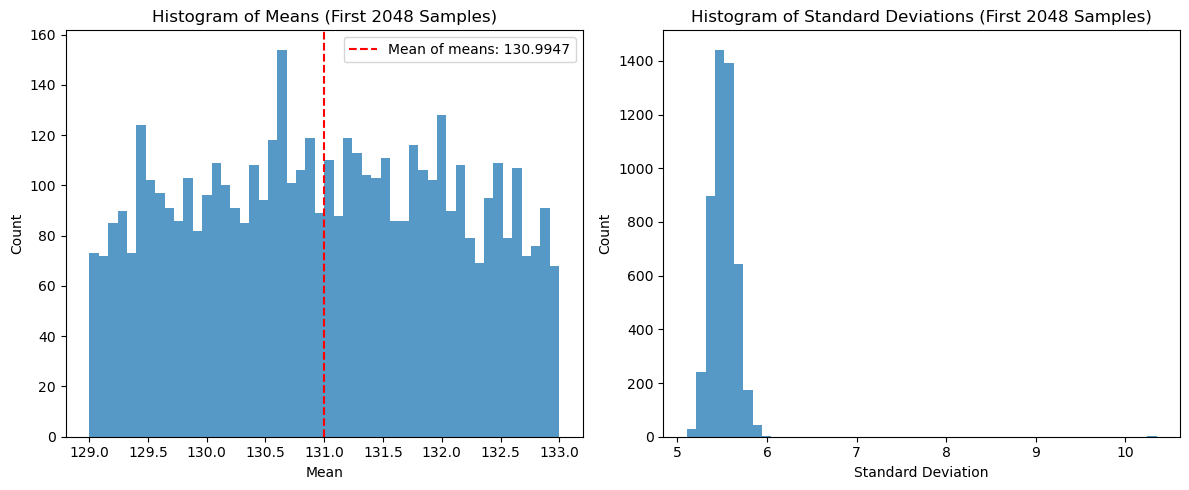

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming traces_a is a NumPy array of shape (4364, 32768)

# Extract the first 2048 samples of each trace
first_2048 = traces[:, :2048]

# Calculate the mean and std for each trace (along axis 1)
means = np.mean(first_2048, axis=1)
stds = np.std(first_2048, axis=1)

# Compute the overall mean of the means
mean_of_means = np.mean(means)

# Plot histograms
plt.figure(figsize=(12, 5))

# Plot mean histogram
plt.subplot(1, 2, 1)
plt.hist(means, bins=50, alpha=0.75)
plt.axvline(mean_of_means, color='red', linestyle='--', label=f"Mean of means: {mean_of_means:.4f}")
plt.title("Histogram of Means (First 2048 Samples)")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.legend()

# Plot std histogram
plt.subplot(1, 2, 2)
plt.hist(stds, bins=50, alpha=0.75)
plt.title("Histogram of Standard Deviations (First 2048 Samples)")
plt.xlabel("Standard Deviation")
plt.ylabel("Count")

plt.tight_layout()
plt.show()



In [11]:
means.shape

(2048,)

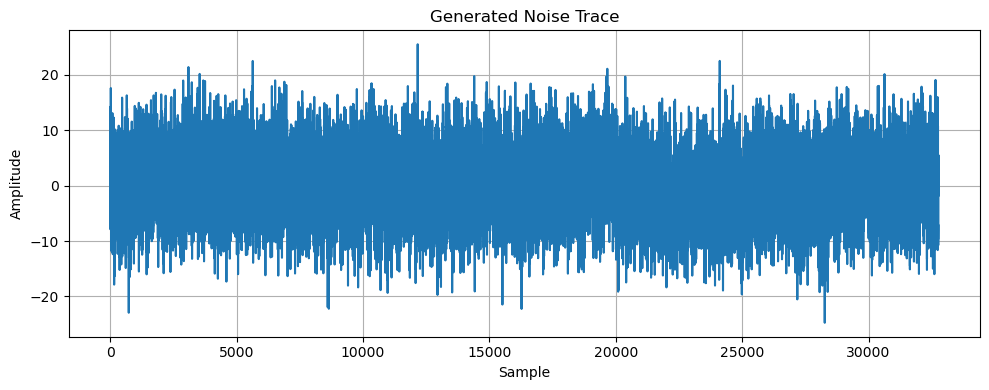

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfftfreq, irfft
from scipy.interpolate import interp1d

class NoiseGenerator:
    def __init__(self, sampling_frequency, trace_samples, noise_path, noise_power):
        self.sampling_frequency = sampling_frequency
        self.trace_samples = trace_samples
        self.noise_path = noise_path
        self.psd_area = noise_power
        self.noise_type = 'custom'
        self._spectra = {}
        self._normalize = {}
        self._load_psd()

    def _load_psd(self):
        # Load the PSD from file: shape (2, N): [frequencies], [psd_values]
        self.noise_psd_data = np.load(self.noise_path)
        self._spectra['custom'] = interp1d(self.noise_psd_data[0], self.noise_psd_data[1],
                                           fill_value=(self.noise_psd_data[1][0], self.noise_psd_data[1][-1]),
                                           bounds_error=False)
        self._normalize['custom'] = lambda f: np.ones_like(f)

    def spectrum(self, f):
        return self._spectra[self.noise_type](f)

    def generate_noise(self):
        N = self.trace_samples
        fs = self.sampling_frequency
        f = rfftfreq(N, d=1.0 / fs)

        # Normalization factor explained in your original comments
        norm = 0.5 * self.psd_area * self._normalize[self.noise_type](f) * fs * N
        psd = norm * self.spectrum(f)

        # Custom PSD adjustment
        if self.noise_type == 'custom':
            psd /= (0.5 * self.psd_area)
            psd[1:N//2 + 1 - (N + 1) % 2] *= 0.5  # avoid modifying Nyquist bin for even N

        psd = np.sqrt(psd)

        # Random phase and time-domain noise
        phi = np.random.uniform(0, 2 * np.pi, len(psd))
        spectrum = psd * np.exp(1j * phi)
        noise = irfft(spectrum)

        return noise

# --- Usage Example ---

# Parameters
sampling_frequency = 3_906_250
trace_samples = 32768
noise_path = "/ceph/dwong/delight/templates/noise_psd_xray.npy"
noise_power = 33.2

# Generate noise
ng = NoiseGenerator(sampling_frequency, trace_samples, noise_path, noise_power)
noise = ng.generate_noise()

# Plot the generated noise
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(noise)
plt.title("Generated Noise Trace")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Count')

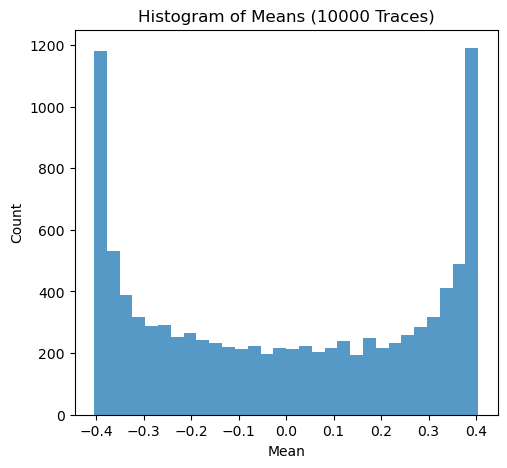

In [55]:
# --- Parameters ---
sampling_frequency = 3_906_250
trace_samples = 32768
noise_path = "/ceph/dwong/delight/templates/noise_psd_xray.npy"
noise_power = 33.2

# --- Generate 100 Noise Traces ---
ng = NoiseGenerator(sampling_frequency, trace_samples, noise_path, noise_power)
num_traces = 10000

traces = np.array([ng.generate_noise() for _ in range(num_traces)])

# --- Compute Mean and Std ---
means = np.mean(traces, axis=1)

# --- Plot Histograms ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(means, bins=30, alpha=0.75)
plt.title("Histogram of Means (10000 Traces)")
plt.xlabel("Mean")
plt.ylabel("Count")


In [16]:
means.shape

(1000,)

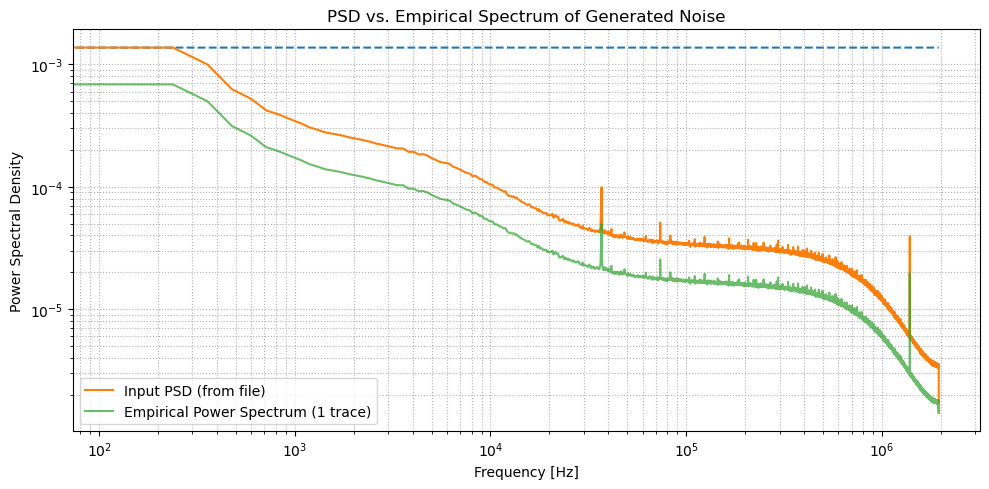

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfftfreq, rfft, irfft
from scipy.interpolate import interp1d

# --- Load PSD ---
noise_psd_data = np.load("/ceph/dwong/delight/templates/noise_psd_xray.npy")
freq_psd = noise_psd_data[0]
psd_values = noise_psd_data[1]
psd_interp = interp1d(freq_psd, psd_values, fill_value=(psd_values[0], psd_values[-1]), bounds_error=False)

# --- Parameters ---
N = 32768
fs = 3_906_250
psd_area = 33.2

# --- Frequencies for FFT ---
f = rfftfreq(N, d=1.0 / fs)
psd = 0.5 * psd_area * fs * N * psd_interp(f)
psd /= (0.5 * psd_area)
psd[1:N//2 + 1 - (N + 1) % 2] *= 0.5
psd = np.sqrt(psd)

# --- Generate noise from PSD ---
phi = np.random.uniform(0, 2 * np.pi, len(psd))
spectrum = psd * np.exp(1j * phi)
noise = irfft(spectrum)

# --- Compute empirical power spectrum of generated noise ---
empirical_spectrum = rfft(noise)
empirical_power = np.abs(empirical_spectrum)**2 / (fs * N)

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.loglog(f, psd_values[0] * np.ones_like(f), '--', label="Flat PSD" if np.allclose(psd_values, psd_values[0]) else None)
plt.loglog(freq_psd, psd_values, label="Input PSD (from file)")
plt.loglog(f, empirical_power, alpha=0.7, label="Empirical Power Spectrum (1 trace)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density")
plt.title("PSD vs. Empirical Spectrum of Generated Noise")
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


In [52]:
config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)

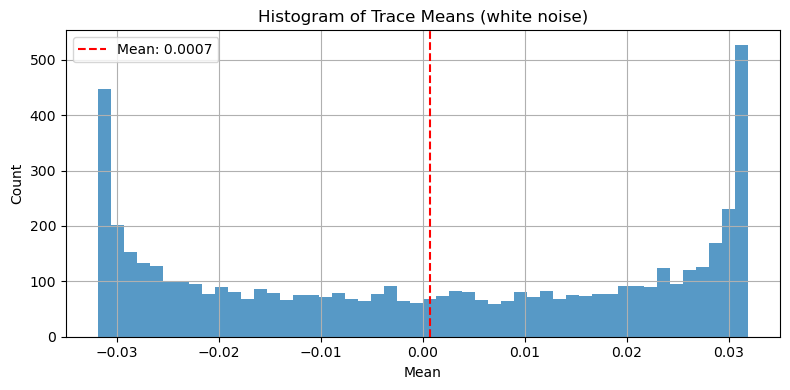

In [53]:
import numpy as np
import matplotlib.pyplot as plt

means = []

# Generate 100 sets of traces
for _ in range(100):
    trace_batch = ts.generate(
        E=0,
        x=-40, y=80, z=-1800,
        no_noise=False,
        type_recoil='NR',
        quantize=False,
        phonon_only=False
    )  # shape assumed to be (1, num_traces_per_batch, trace_length)

    batch = trace_batch[0]  # shape: (num_traces, trace_length)

    for trace in batch:
        means.append(np.mean(trace))

# Plot histogram of means
plt.figure(figsize=(8, 4))
plt.hist(means, bins=50, alpha=0.75)
plt.axvline(np.mean(means), color='red', linestyle='--', label=f"Mean: {np.mean(means):.4f}")
plt.title("Histogram of Trace Means (white noise)")
plt.xlabel("Mean")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
